# XRAI for Image Explainability

## Felzenswalb Image Segmentation

/opt/conda/lib/python3.7/site-packages/felzenszwalb_segmentation/utils/filter_utils.py:14: RuntimeWarning: overflow encountered in ubyte_scalars
  src[y, max(x - i, 0)] + src[y, min(x + i, width - 1)])


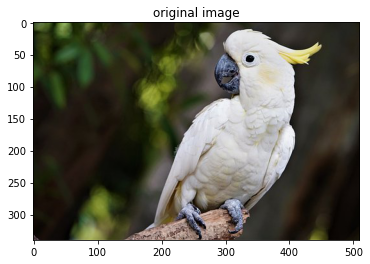

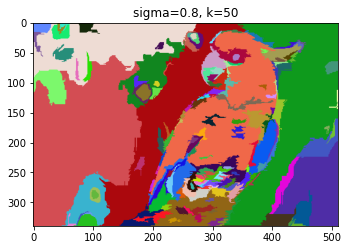

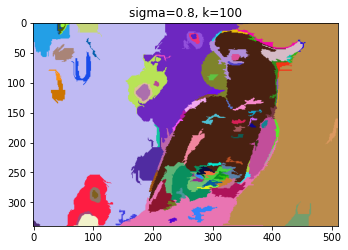

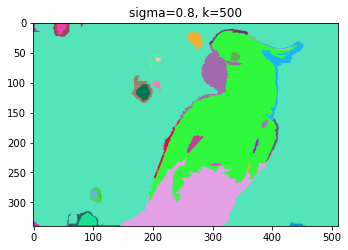

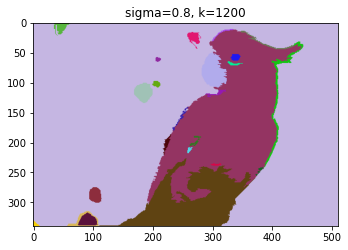

In [9]:
import numpy as np
from glob import glob
from PIL import Image
from matplotlib import pyplot as plt
from felzenszwalb_segmentation import segment

image_files = glob('./images/cockatoo.jpeg')

for image_file in image_files:
    image = np.array(Image.open(image_file))
    plt.imshow(image)
    plt.title("original image")
    for k in [50, 100, 500, 1200]:
        segmented_image = segment(image, 0.8, k, 50)

        fig = plt.figure(figsize=(12, 12))
        a = fig.add_subplot(1, 2, 2)
        plt.imshow(segmented_image.astype(np.uint8))
        plt.title(f"sigma=0.8, k={k}")
        plt.show()

### Image Segmentation using skimage

/opt/conda/lib/python3.7/site-packages/skimage/_shared/utils.py:338: FutureWarning: Providing the `multichannel` argument positionally to felzenszwalb is deprecated. Use the `channel_axis` kwarg instead.
  return func(*args, **kwargs)


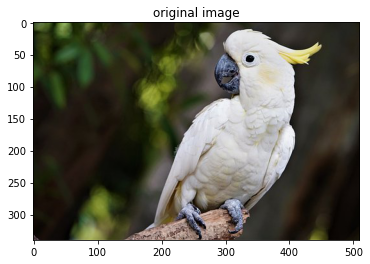

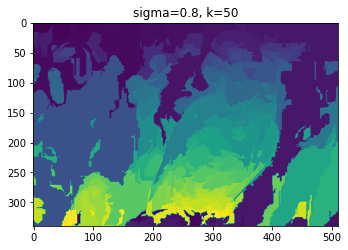

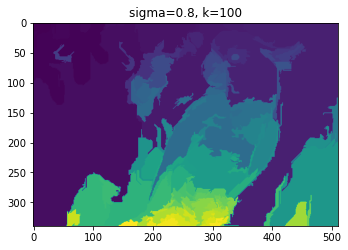

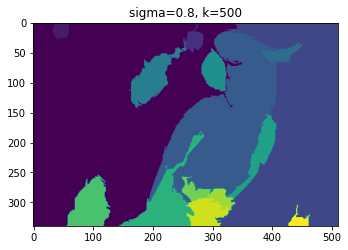

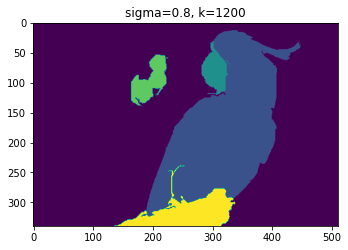

In [16]:
from skimage import segmentation

image_files = glob('./images/cockatoo.jpeg')

for image_file in image_files:
    image = np.array(Image.open(image_file))
    plt.imshow(image)
    plt.title("original image")
    for k in [50, 100, 500, 1200]:
        segmented_image = segmentation.felzenszwalb(image, k, 0.8, k, 200)

        fig = plt.figure(figsize=(12, 12))
        a = fig.add_subplot(1, 2, 2)
        plt.imshow(segmented_image.astype(np.uint8))
        plt.title(f"sigma=0.8, k={k}")
        plt.show()

## Computing saliency masks for XRAI 

Let's use the PAIR saliency library to compute XRAI feature attributions. You need to have the `saliency` pip package installed. To install run (use `pip3` for python 3.x):
```
pip install saliency tensorflow
```

In [1]:
#!pip install saliency tensorflow

In [1]:
# imports
import tensorflow as tf
import numpy as np
import PIL.Image
from matplotlib import pylab as P

import saliency.core as saliency

%matplotlib inline

### Utility methods

In [2]:
def ShowImage(im, title='', ax=None):
  if ax is None:
    P.figure()
  P.axis('off')
  P.imshow(im)
  P.title(title)

def ShowHeatMap(im, title, ax=None):
  if ax is None:
    P.figure()
  P.axis('off')
  P.imshow(im, cmap='inferno')
  P.title(title)

def LoadImage(file_path):
  im = PIL.Image.open(file_path)
  im = im.resize((224,224))
  # im = im.resize((299,299))   # for inceptionV3
  im = np.asarray(im)
  return im

def PreprocessImage(im):
  im = tf.keras.applications.vgg16.preprocess_input(im)
  return im

### Loading the VGG16 model for ImageNet

In [3]:
m = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=True)
conv_layer = m.get_layer('block5_conv3')
model = tf.keras.models.Model([m.inputs], [conv_layer.output, m.output])

2022-04-14 02:48:04.399381: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2022-04-14 02:48:04.399469: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-14 02:48:04.399499: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (vf-asl): /proc/driver/nvidia/version does not exist
2022-04-14 02:48:04.399962: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


`call_model_function` is how we pass inputs to our model and receive outputs necessary to compute saliency masks. The description of this method and necessary outputs is in the base CoreSaliency description, as well as separately for each method.

In [4]:
class_idx_str = 'class_idx_str'
def call_model_function(images, call_model_args=None, expected_keys=None):
    target_class_idx =  call_model_args[class_idx_str]
    images = tf.convert_to_tensor(images)
    with tf.GradientTape() as tape:
        if expected_keys==[saliency.base.INPUT_OUTPUT_GRADIENTS]:
            tape.watch(images)
            _, output_layer = model(images)
            output_layer = output_layer[:,target_class_idx]
            gradients = np.array(tape.gradient(output_layer, images))
            return {saliency.base.INPUT_OUTPUT_GRADIENTS: gradients}
        else:
            conv_layer, output_layer = model(images)
            gradients = np.array(tape.gradient(output_layer, conv_layer))
            return {saliency.base.CONVOLUTION_LAYER_VALUES: conv_layer,
                    saliency.base.CONVOLUTION_OUTPUT_GRADIENTS: gradients}

### Load an image and infer

Prediction class: 89


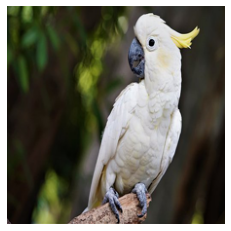

In [5]:
# Load the image
im_orig = LoadImage('./images/cockatoo.jpeg')
im = PreprocessImage(im_orig)

# Show the image
ShowImage(im_orig)

_, predictions = model(np.array([im]))
prediction_class = np.argmax(predictions[0])
call_model_args = {class_idx_str: prediction_class}

print("Prediction class: " + str(prediction_class))  # Should be a doberman, class idx = 236

### XRAI

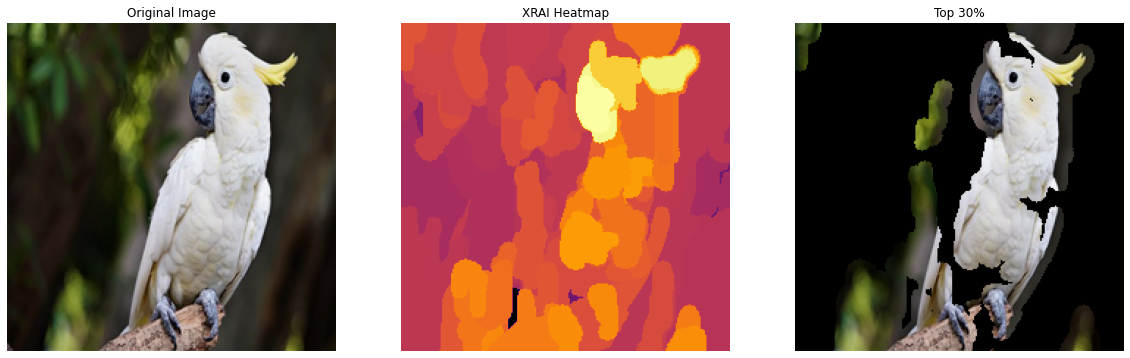

In [7]:
# Construct the saliency object. This alone doesn't do anthing.
xrai_object = saliency.XRAI()

# Compute XRAI attributions with default parameters
xrai_attributions = xrai_object.GetMask(im,
                                        call_model_function,
                                        call_model_args,
                                        batch_size=20)

# Set up matplot lib figures.
ROWS = 1
COLS = 3
UPSCALE_FACTOR = 20
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Show original image
ShowImage(im_orig, title='Original Image', ax=P.subplot(ROWS, COLS, 1))

# Show XRAI heatmap attributions
ShowHeatMap(xrai_attributions, title='XRAI Heatmap', ax=P.subplot(ROWS, COLS, 2))

# Show most salient 30% of the image
mask = xrai_attributions > np.percentile(xrai_attributions, 60)
im_mask = np.array(im_orig)
im_mask[~mask] = 0
ShowImage(im_mask, title='Top 30%', ax=P.subplot(ROWS, COLS, 3))

### XRAI fast version

In [ ]:
# Create XRAIParameters and set the algorithm to fast mode which will produce an approximate result.
xrai_params = saliency.XRAIParameters()
xrai_params.algorithm = 'fast'

# Compute XRAI attributions with fast algorithm
xrai_attributions_fast = xrai_object.GetMask(im, call_model_function, call_model_args, extra_parameters=xrai_params, batch_size=20)

# Set up matplot lib figures.
ROWS = 1
COLS = 3
UPSCALE_FACTOR = 20
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Show original image
ShowImage(im_orig, title='Original Image', ax=P.subplot(ROWS, COLS, 1))

# Show XRAI heatmap attributions
ShowHeatMap(xrai_attributions_fast, title='XRAI Heatmap', ax=P.subplot(ROWS, COLS, 2))

# Show most salient 30% of the image
mask = xrai_attributions_fast > np.percentile(xrai_attributions_fast, 70)
im_mask = np.array(im_orig)
im_mask[~mask] = 0
ShowImage(im_mask, 'Top 30%', ax=P.subplot(ROWS, COLS, 3))

In [ ]:
# Create XRAIParameters and set the algorithm to fast mode which will produce an approximate result.
xrai_params = saliency.XRAIParameters()
xrai_params.steps = 200

# Compute XRAI attributions with fast algorithm
xrai_attributions_fast = xrai_object.GetMask(im,
                                             call_model_function,
                                             call_model_args,
                                             extra_parameters=xrai_params,
                                             batch_size=20)

# Set up matplot lib figures.
ROWS = 1
COLS = 3
UPSCALE_FACTOR = 20
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Show original image
ShowImage(im_orig, title='Original Image', ax=P.subplot(ROWS, COLS, 1))

# Show XRAI heatmap attributions
ShowHeatMap(xrai_attributions_fast, title='XRAI Heatmap', ax=P.subplot(ROWS, COLS, 2))

# Show most salient 30% of the image
mask = xrai_attributions_fast > np.percentile(xrai_attributions_fast, 70)
im_mask = np.array(im_orig)
im_mask[~mask] = 0
ShowImage(im_mask, 'Top 30%', ax=P.subplot(ROWS, COLS, 3))